# HW9: Forecasting Solar Cycles

Below is the notebook associated with HW\#9. You can run the notebook in two modes. If you have the `emcee` and `corner` packages installed on your machine, along with the data files, just keep the following variable set to `False`. If you are running it in a Google colab notebook, set it to `True` so that it will grab the packages and files. Remember that the Google colab environment will shutdown after ~1 hour of inactivity, so you'll need to keep interacting with it or else will lose the data.

A script version of this file will also be provided to you, but you cannot use this in a Google colab environment

In [1]:
COLAB = False

In [2]:
if COLAB:
    # Install emcee package
    !pip install emcee
    # Install corner package
    !pip install corner    
    # Grab sunspot data file
    !wget -O SN_m_tot_V2.0.txt https://raw.githubusercontent.com/mtlam/ASTP-720_F2020/master/HW9/SN_m_tot_V2.0.txt

In [3]:
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
import emcee
import corner
%matplotlib inline

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## The Model

I will define a seasonal autoregressive model as follows. For the short-term piece, I will include two AR terms just for fun. Then I will include one yearly term and one solar-cycle term. We can write this in the form:

$$S_t - \phi_1 S_{t-1} - \phi_2 S_{t-2} - \phi_{12} S_{t-12} - \phi_{132} S_{t-132} = Z_t$$

where $S_t$ is the sunspot number, $Z_t$ is the random "shock"/perturbation, and the times are measured in months. This is a little different than a SARMA$(2, 0)\times (1, 0)_{12} \times (1, 0)_{132}$ model because we would write such a model in the form

$$\phi(B) \Phi_{\rm year}(B^{12}) \Phi_{\rm cycle}(B^{132}) S_t = Z_t$$,

where $B$ is the usual backshift operator defined by $B X_t = X_{t-1}$. In this case, we would multiply the three polynomials to arrive at a form that's similar in spirit to the first equation but with slight differences, for example:

$$ (1-\phi'_1 B - \phi'_2 B^2)(1-\phi'_{12} B^{12})(1-\phi'_{132} B^{132}) S_t = Z_t$$

I use primes to denote that these are note the same coefficients as above. Notice that in expanding out this model, there would be a $B^{145}$ term i there. It probably makes sense that there should be some correlation between the current step and the step 145 months ago *if* there are correlations on the 1 and 2 month scales, 1 year scales, and 11-year scales. I put it out there since it is another possible way of modeling and a more general model for including seasonality in ARMA processes than the one first written.

**Note that a yearly term does not make physical sense.** I'm a pulsar astronomer and was thinking about the orbital motion of the Earth around the Sun and how the line of sight to a pulsar changes throughout the year - the closer that line gets to the Sun, there is an increase in the *dispersion measure*. Sunspots don't know about the Earth's motion. A yearly cycle *could* model if there is some observational effect from measurements taken in one hemisphere versus another but it's probably unlikely given they are measured internationally and averaged down each month.

With that, let's get modeling...

I'm going to define a few constants here for ease

In [4]:
C = 11*12
MIN = -2.0
MAX = 2.0

## Define the (log-)priors

Here, the function should take a vector of parameters, `theta`, and return `0.0` if the it is in the prior range and `-np.inf` if it is outside. This is equivalent to a uniform prior over the parameters. You can, of course, define a different set of priors if you so choose!

In [5]:
def lnprior(theta):
    """
    log-prior. The last parameter is sigma and the others are the phi parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
        
    Returns
    -------
    Value of log-prior.    
    """
    if np.all((MIN<theta[:-1])&(theta[:-1]<MAX)) and 0 < theta[-1] < 200:
        return 0.0
    return -np.inf

## Define the (log-)likelihood

We will use array slicing here rather than loops to speed up the calculation significantly.

In [6]:
def lnlike(theta, data):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
    data : np.ndarray
        
        
    Returns
    -------
    Value of log-likelihood   
    """
    
    phi1, phi2, phi12, phi132, sigma = theta
    
    residuals = data[C:] - phi1*data[C-1:-1] - phi2*data[C-2:-2] - phi12*data[C-12:-12] - phi132*data[:-C]
    
    return -0.5 * np.power(residuals/sigma, 2).sum() - len(residuals)*np.log(sigma)

## Define total (log-)probability

No need to change this if the other two functions work as described.

In [7]:
def lnprob(theta, data):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data)

## Set up the MCMC sampler here

In [8]:
# Number of walkers to search through parameter space
nwalkers = 10
# Number of iterations to run the sampler for
niter = 50000
# Initial guess of parameters. For example, if you had a model like
# s(t) = a + bt + ct^2
# and your initial guesses for a, b, and c were 5, 3, and 8, respectively, then you would write
# pinit = np.array([5, 3, 8])
# Make sure the guesses are allowed inside your lnprior range!
pinit = np.array([0.5, 0.5, 0.5, 0.5, 100])
# Number of dimensions of parameter space
ndim = len(pinit)
# Perturbed set of initial guesses. Have your walkers all start out at
# *slightly* different starting values
p0 = [pinit + 1e-4*pinit*np.random.randn(ndim) for i in range(nwalkers)]

## Load the data, plot to show

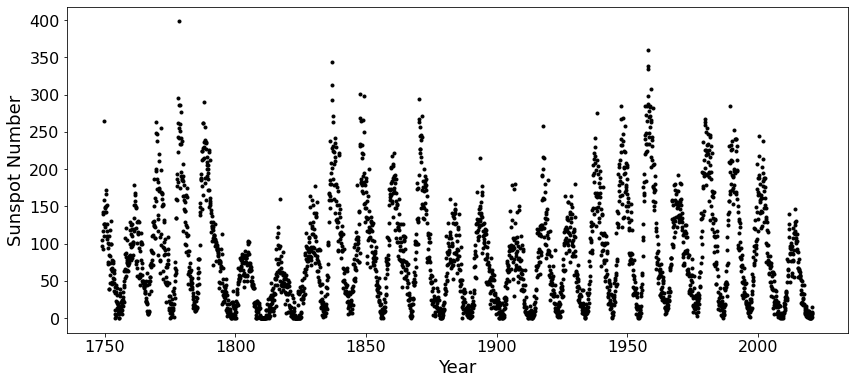

In [9]:
# Data: decimal year, sunspot number
decyear, ssn = np.loadtxt("SN_m_tot_V2.0.txt", unpack=True, usecols=(2, 3))
figure(figsize=(14, 6))
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

## Run the sampler

In [10]:
# Number of CPU threads to use. Reduce if you are running on your own machine
# and don't want to use too many cores
nthreads = 4
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ssn,), threads=nthreads)
# Run the sampler. May take a while! You might consider changing the 
# number of iterations to a much smaller value when you're testing. Or use a 
# larger value when you're trying to get your final results out!
output = sampler.run_mcmc(p0, niter, progress=True) #capture output to prevent printing

100%|██████████| 50000/50000 [01:02<00:00, 804.64it/s]


## Get the samples in the appropriate format, with a burn value

In [11]:
# Burn-in value = 1/4th the number of iterations. Feel free to change!
burn = int(0.25*niter)
# Reshape the chains for input to corner.corner()
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

## Make a corner plot

You should feel free to adjust the parameters to the `corner` function. You **should** also add labels, which should just be a list of the names of the parameters. So, if you had two parameters, $\phi_1$ and $\phi_2$, then you could write:

```
labels = [r"$\phi_1$", r"$\phi_2$"]
```

and that will make the appropriate label in LaTeX (if the distribution is installed correctly) for the two 1D posteriors of the corner plot.

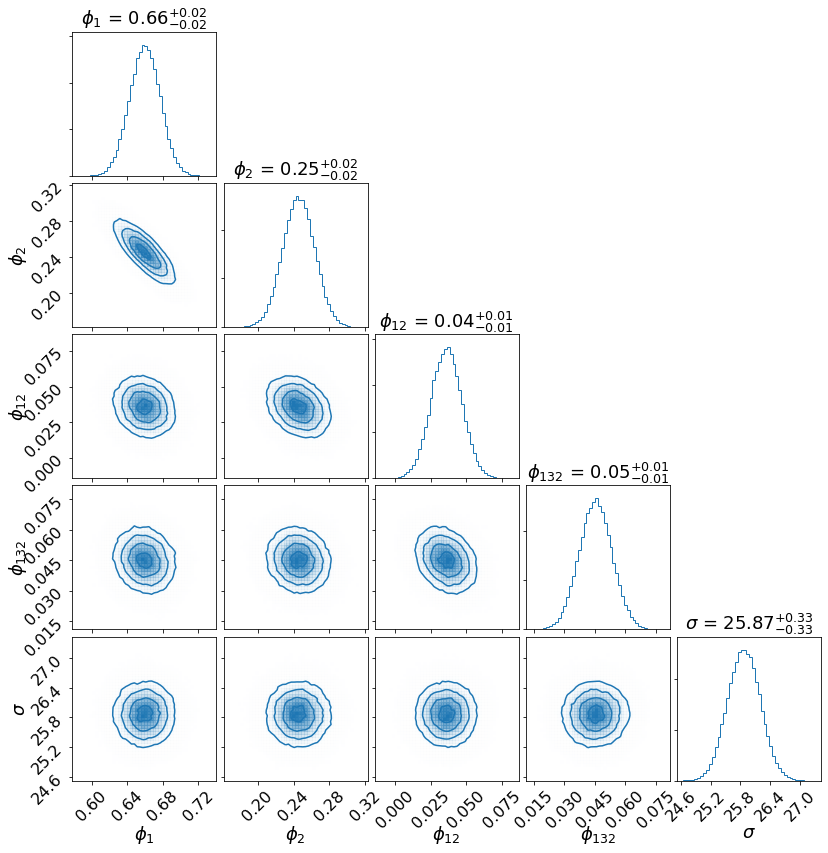

In [12]:
labels = [r"$\phi_1$", r"$\phi_2$", r"$\phi_{12}$", r"$\phi_{132}$", r"$\sigma$"]

fig = corner.corner(samples, bins=50, color='C0', smooth=0.5, plot_datapoints=False, plot_density=True, \
                    plot_contours=True, fill_contour=False, show_titles=True, labels=labels)
fig.savefig("corner.png")
show()

As we can see, the posteriors are quite well defined. This doesn't say anything about the fit of the model, just that there is a peak in the probability. For simplicity, I will take the median values for each of the chains as the parameters going forward

In [13]:
phi1_hat = np.median(samples[:, 0])
phi2_hat = np.median(samples[:, 1])
phi12_hat = np.median(samples[:, 2])
phi132_hat = np.median(samples[:, 3])
sigma_hat = np.median(samples[:, 4])

## (Remainder of) Q2: Fit of the model

Remember that the residuals are just the data minus the model. So to get the model, we take the data minus the residuals. We'll leave out the first cycle from the fit as we're only considering the *conditional* likelihood above for simplicity.

In [14]:
residuals = ssn[C:] - phi1_hat*ssn[C-1:-1] - phi2_hat*ssn[C-2:-2] - phi12_hat*ssn[C-12:-12] - phi132_hat*ssn[:-C]

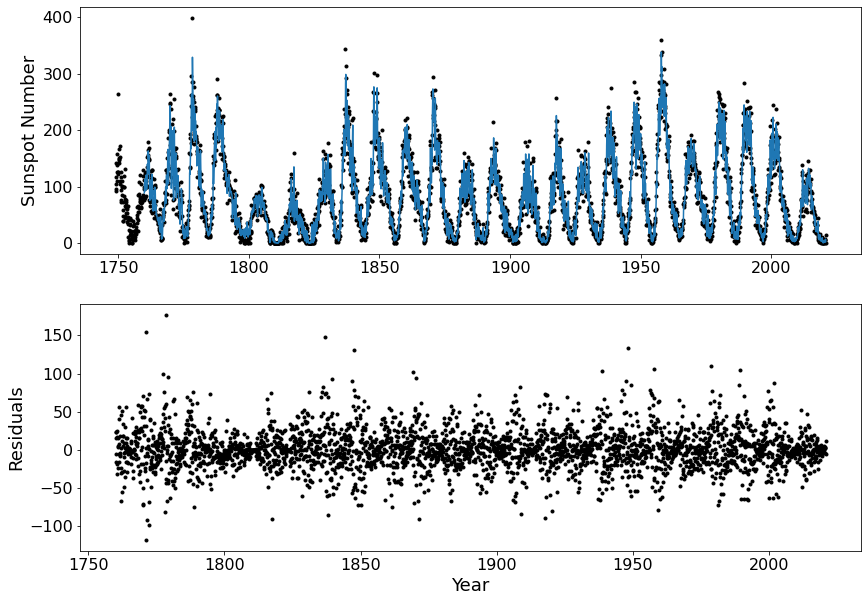

In [15]:
figure(figsize=(14, 10))
subplot(211)
plot(decyear, ssn, 'k.')
plot(decyear[C:], ssn[C:]-residuals)
ylabel('Sunspot Number')
subplot(212)
plot(decyear[C:], residuals, 'k.')
xlabel('Year')
ylabel('Residuals')
show()

We can still see some remaining structure in the residuals, suggesting that we're not accounting for everything in our model. 

## Q3: Spectrum of the model

Plot the spectrum of your model. Please describe its behavior(s), for example at low/high/peak frequencies.

-----

The spectrum for a generic AR$(p)$ process (no MA component) $X_t$ can be written as 

$$S_X(f) = \sigma_Z^2 \frac{1}{| \phi(e^{-2\pi i f})|^2}\quad\quad 0 \leq f \leq \frac{1}{2}$$.

In this case, we then have that 

$$S_S(f) = \sigma_Z^2 \frac{1}{| 1- \phi_1 e^{-2\pi i f} - \phi_2 e^{-2 \cdot 2\pi i f} - \phi_{12} e^{-12 \cdot2\pi i f} - \phi_{132} e^{-132\cdot 2\pi i f}|^2}\quad\quad 0 \leq f \leq \frac{1}{2}$$.

As always, be careful with the units. The integration of the spectrum produces the variance, so there is an implicit time/frequency unit factor embedded here.

Text(0, 0.5, '$S_s(f)$')

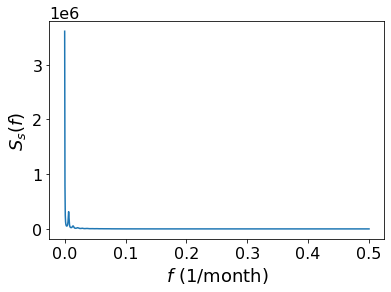

In [16]:
f = np.linspace(0, 0.5, 1000)
exp = lambda n, f: np.exp(-n*2*np.pi*1j*f)

S = sigma_hat**2 / np.abs(1 - phi1_hat*exp(1, f) - phi2_hat*exp(2, f)
                         - phi12_hat*exp(12, f) - phi132_hat*exp(132, f))**2

plot(f, S)
xlabel('$f$ (1/month)')
ylabel(r'$S_s(f)$')

There is more power at low frequencies than high frequencies, which makes sense given the correlated nature of the data. In log-space:

Text(0, 0.5, '$S_s(f)$')

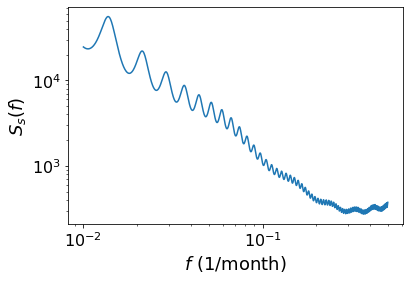

In [17]:
f = np.geomspace(0.01, 0.5, 1000) #use these to avoid taking log(0) in the plot

S = sigma_hat**2 / np.abs(1 - phi1_hat*exp(1, f) - phi2_hat*exp(2, f)
                         - phi12_hat*exp(12, f) - phi132_hat*exp(132, f))**2

plot(f, S)
xscale('log')
yscale('log')
xlabel('$f$ (1/month)')
ylabel(r'$S_s(f)$')

We can see that this is clearly red noise, with significant power at lower frequencies.

## Q4: Forecasting

Using the parameters of your model, as well as $\sigma_Z$ either derived from your MCMC fit or estimated
from the residuals after your fit, predict the sunspot number out to the year 2050.

-----

Since we know what the AR coefficients are, we can predict ahead. Since the last date is in late 2020, for simplicity we can project forward another $30\times 12 = 360$ months. Let's first get the extended time values, then look at extending the model.

In [18]:
extended_decyear = np.concatenate((decyear, np.zeros(360)))
extended_decyear[-360:] += 30 + decyear[-360:]

In [19]:
extended_ssn = np.concatenate((ssn, np.zeros(360)))
N = len(ssn)

for i in range(360):
    extended_ssn[N+i] = phi1_hat*extended_ssn[N+i-1] + phi2_hat*extended_ssn[N+i-2] + \
                        phi12_hat*extended_ssn[N+i-12] + phi132_hat*extended_ssn[N+i-132] 

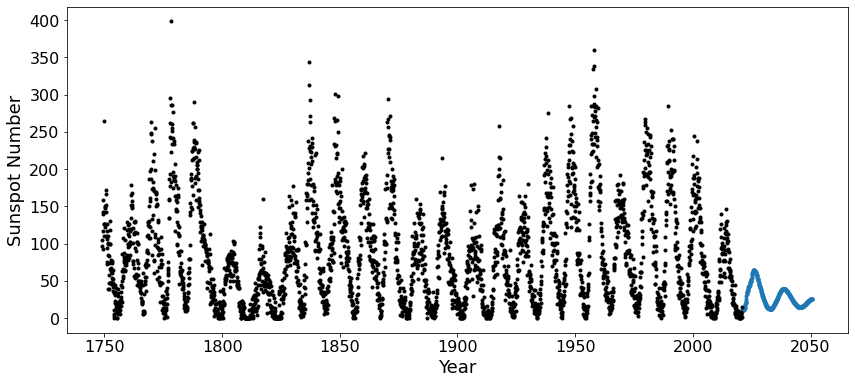

In [20]:
figure(figsize=(14, 6))
plot(extended_decyear[-360:], extended_ssn[-360:], 'C0.')
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

Now let's incorporate some error region. Let's now make one *realization* of some future values. I can simulate a single realization going forward by just sampling a normal distribution $Z_t \sim \mathcal{N}(0, \sigma_Z^2)$ and using the AR coefficients to forecast ahead. We also impose the condition that the sunspot number must be positive. Therefore, I will cheat a little bit and just say that if the sunspot number would be negative, set it to zero. This does mean that sometimes you can get clumps of sunspots near zero for several months, but this is actually a possibility at solar minimum anyway. 

In [21]:
np.random.seed(42) #just for consistency on plots after this moment.

extended_ssn = np.concatenate((ssn, np.zeros(360)))
N = len(ssn)

for i in range(360):
    Z_t = np.random.normal(0, sigma_hat)
    extended_ssn[N+i] = phi1_hat*extended_ssn[N+i-1] + phi2_hat*extended_ssn[N+i-2] + \
                        phi12_hat*extended_ssn[N+i-12] + phi132_hat*extended_ssn[N+i-132] + Z_t
    if extended_ssn[N+i] < 0:
        extended_ssn[N+i] = 0

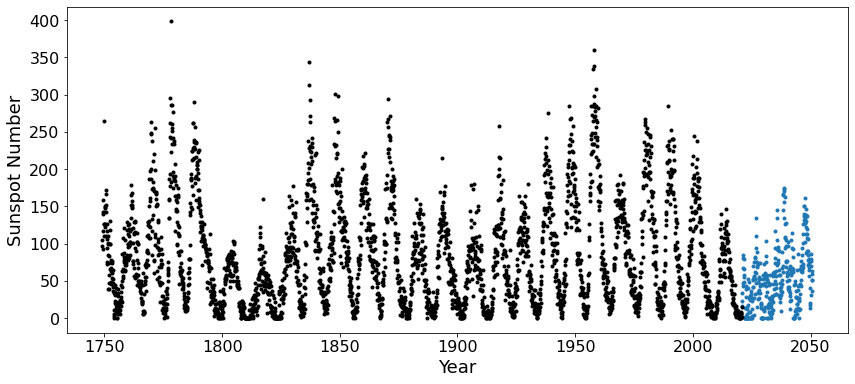

In [22]:
figure(figsize=(14, 6))
plot(extended_decyear[-360:], extended_ssn[-360:], 'C0.')
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

We can see that we do an okay job but not great. At the very lowest parts when the sunspot number reaches zero, we don't do as well. This is because when we are at a sunspot number of 10, say, then a Gaussian perturbation with standard deviation of 25 or so doesn't quite make sense. So this is one of the places the model breaks down.

-----

Let's look at an error region by running multiple realizations an showing the average/spread:

In [23]:
M = 10
extended_ssns = np.zeros((M, N+360))


for m in range(M): #number of realizations
    extended_ssns[m, :-360] = ssn
    for i in range(360):
        Z_t = np.random.normal(0, sigma_hat)
        extended_ssns[m, N+i] = phi1_hat*extended_ssns[m, N+i-1] + phi2_hat*extended_ssns[m, N+i-2] + \
                                phi12_hat*extended_ssns[m, N+i-12] + phi132_hat*extended_ssns[m, N+i-132] + Z_t
        if extended_ssns[m, N+i] < 0:
            extended_ssns[m, N+i] = 0

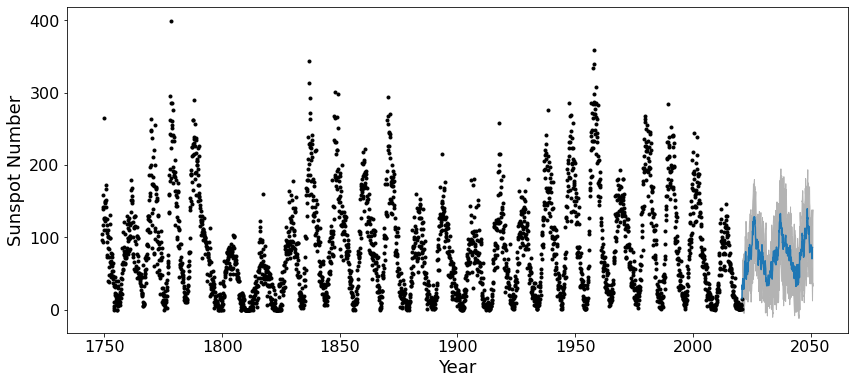

In [24]:
average_ssn = np.mean(extended_ssns[:, -360:], axis=0)
stdev_ssn = np.std(extended_ssns[:, -360:], axis=0)

figure(figsize=(14, 6))
plot(decyear, ssn, 'k.')
plot(extended_decyear[-360:], average_ssn, 'C0')
fill_between(extended_decyear[-360:], average_ssn-stdev_ssn, average_ssn+stdev_ssn, color='0.70')
xlabel('Year')
ylabel('Sunspot Number')
show()

We can see that on the average, we are capturing the periodic structure. Any one given realization is quite noisy, however.

## Bonus: 

Recall the Akaike Information Criterion as a way of determining a preferred model, defined as

$$ \text{AIC} = 2k − 2 \ln \mathcal{L}_{\rm max},$$

where $k$ is the number of parameters of the model and $\ln\mathcal{L}_{\rm max}$ is the maximum value of the likelihood. Create two different models from the one you have made above. For all three, calculate the parameters
and the AIC value. Determine which model is preferred and offer some interpretation of the values


-----

We'll consider two models. In one, we will remove that yearly term, so will have a model of the form:

$$S_t - \phi_1 S_{t-1} - \phi_2 S_{t-2} - \phi_{132} S_{t-132} = Z_t$$.

In the second, we'll remove the yearly term but write tis in the SARMA$(2, 0) \times (1, 0)_{132}$ form:

$$ (1-\phi'_1 B - \phi'_2 B^2)(1-\phi'_{132} B^{132}) S_t = Z_t$$.


In [25]:
#TBD